In [1]:
!pip install packaging

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-07-12 13:49:31.903289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 13:49:31.903346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 13:49:31.904552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 13:49:31.911293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-12 13:49:32.760650: W tensorflow/compiler/tf2

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
LATENT_DIM  = 32          # bottleneck size
IMG_SHAPE   = (28, 28, 1) # MNIST default
NUM_SAMPLES = 5           # how many images to generate
NOISE_MEAN  = 5.0
NOISE_VAR   = 1.0

In [4]:
(x_train, _), _ = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)   # (N, 28, 28, 1)

11490434/11490434 [==============================] - 4s 0us/step


In [5]:
def build_encoder():
    inputs = keras.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(LATENT_DIM, name="latent")(x)
    return keras.Model(inputs, latent, name="encoder")

def build_decoder():
    latent_inputs = keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, outputs, name="decoder")

encoder  = build_encoder()
decoder  = build_decoder()

2025-07-12 13:49:39.581560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-12 13:49:40.055128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
ae_inputs  = keras.Input(shape=IMG_SHAPE)
encoded    = encoder(ae_inputs)
recon      = decoder(encoded)
normal_ae  = keras.Model(ae_inputs, recon, name="normal_ae")

normal_ae.compile(optimizer="adam", loss="binary_crossentropy")
normal_ae.fit(x_train, x_train,
              epochs=2, batch_size=256, shuffle=True, verbose=2)  # quick demo

Epoch 1/2
235/235 - 36s - loss: 0.2344 - 36s/epoch - 154ms/step
Epoch 2/2
235/235 - 35s - loss: 0.0950 - 35s/epoch - 148ms/step


In [7]:
noise_layer = layers.GaussianNoise(stddev=0.4)  # typical noise level
dae_inputs  = keras.Input(shape=IMG_SHAPE)
noisy       = noise_layer(dae_inputs, training=True)
dae_encoded = encoder(noisy)         # reuse the same encoder architecture
dae_recon   = decoder(dae_encoded)   # and same decoder weights (fresh start)
denoise_ae  = keras.Model(dae_inputs, dae_recon, name="denoise_ae")

denoise_ae.compile(optimizer="adam", loss="binary_crossentropy")
denoise_ae.fit(x_train, x_train,
               epochs=2, batch_size=256, shuffle=True, verbose=2)

Epoch 1/2
235/235 - 36s - loss: 0.1100 - 36s/epoch - 153ms/step
Epoch 2/2
235/235 - 35s - loss: 0.0993 - 35s/epoch - 150ms/step


In [8]:
def sample_noise(mean, var, n, dim):
    return np.random.normal(loc=mean,
                            scale=np.sqrt(var),
                            size=(n, dim)).astype("float32")

In [9]:
def generate_and_plot(decoder, title):
    z      = sample_noise(NOISE_MEAN, NOISE_VAR, NUM_SAMPLES, LATENT_DIM)
    imgs   = decoder.predict(z, verbose=0).clip(0, 1)
    plt.figure(figsize=(NUM_SAMPLES*2, 2.3))
    for i in range(NUM_SAMPLES):
        ax = plt.subplot(1, NUM_SAMPLES, i+1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

# 6. Question 1 – Normal Autoencoder

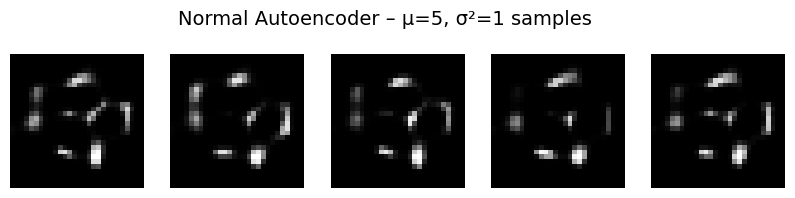

In [10]:
generate_and_plot(decoder, "Normal Autoencoder – μ=5, σ²=1 samples")

# 7. Question 2 – Denoising Autoencoder

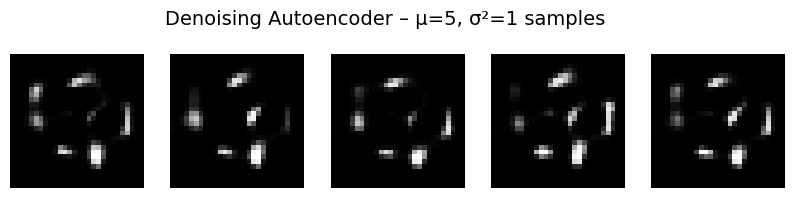

In [11]:
generate_and_plot(decoder, "Denoising Autoencoder – μ=5, σ²=1 samples")